# Fail/Pass tests and the implied failure rate and confidence levels

Let's say we conduct a fail/pass test. 
We subject $n_\mathrm{s}$ samples to an accelerated (representative) life test of $m=1$ lifetime equivalents. 
The test is considered a success if $100\,\%$ of the $n_\mathrm{s}$ samples survive. 
Yet, this leaves the important question of how certain can we be that the population as a whole (from which the $n_\mathrm{s}$ samples are a representative sub-set) will survive the $m=1$ lifetime equivalents? 
And, apart from the implied confidence level, what fraction of the population is still expected to fail even if $100\,\%$ of the $n_\mathrm{s}$ samples did survive? 

We consider a binomial distribution: the samples either survive (pass), or die (fail). 
Each sample has a probability $p$ of dying. 
Hence, starting with $n_\mathrm{s}$ samples, the probability of ending up with $k$ dead (failed) samples is

$$
B(k) = \frac{n_\mathrm{s}!}{k!(n_\mathrm{s}-k)!} p^k (1-p)^{(n_\mathrm{s}-k)}.
$$

The case of interest is with $k=0$ dead samples at the end of the test, i.e. all passed. 
This leaves us with the special case of

\begin{equation}
B(0) = (1-p)^{n_\mathrm{s}}.
\label{eq:B0}
\end{equation}

With $p$ being the probability of dying, $(1-p)=R$ can be said to be a measure of the reliability (in the sense of the probability to survive the foreseen lifetime) of the devices being tested. 
The probability $B(0)$ represents a measure of how often we expect to see this survival rate. 
In other words, it is $B(0)=(1-C)$, with $C$ the confidence level.

In other words, we can rewrite Eq. (\ref{eq:B0}) as
\begin{equation}
(1-C) = R^{n_\mathrm{s}}.
\label{eq:CRn}
\end{equation}

And from Eq. (\ref{eq:CRn}) follows how $n_\mathrm{s}$ relates to $R$ and $C$:

\begin{equation}
n_\mathrm{s} = \frac{\ln(1-C)}{\ln(R)}.
\label{eq:n_lnCR}
\end{equation}

We can reuse already tested samples and expose them to the accelerated life test a second, third, ... , $m$ time. 
Up to a certain point this would be equivalent a higher number of samples. 
Written differently,

$$
n_\mathrm{s} = m \times n_\mathrm{actual\_samples},
$$

and thus

$$
n_\mathrm{s} = \frac{\ln(1-C)}{m \ln(R)}.
$$

Sidenote, it should be clear that a test conducted with only one sample but which was exposed to $m=100$ lifetimes would NOT be statistically equally meaningful as a test with $100$ samples exposed to $m=1$ lifetime. 
In what context $m>1$ might be meaningful depends on various circumstances.

The confidence level $C$ is a critical parameter of a fail/pass test. 
The purpose of a fail/pass test is to learn something 
(that's the purpose of any test, of course, not only fail/pass). 
Often this tool comes into play to confirm that a new product can be launched. 
However, testing costs money (for the samples) and time (for the actual testing). 
Hence, small sample sizes are typically preferred.

Yet, confirmation bias aside, what can we possibly learn from a passed test with few samples? 
Let me assume an extreme case example: testing two samples, which are so inherently flawed that they fail half of the time.
Such a test will fail in $C=75\,\%$ of the time. 
Upon failure the development team would likely investigate the failed sample and subsequently improve it. 
This could be considered a good outcome. 
On the other hand, starting off with an only $R=50\,\%$ reliable product left a lot of room for improvement.

And maybe even worse, there are still $B(0)=25\,\%$ of the time in which the two samples do NOT fail, 
$25\,\%$ of the time in which the team would not investigate the failure mechanisms, and
$25\,\%$ of the time in which the product launch would continue according to schedule and being shipped. 
It should be without saying, no customer is interested in a $R=50\,\%$ reliable product. 

If the product was slightly more reliable (say, a still rather bad $R=70\,\%$), 
the two samples would pass in $B(0)=49\,\%$ of the cases. 
In other words, the fail/pass test would be only just slightly more informative than an independent coin-flip!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline


## Analytical examples

In [2]:
C = 0.9
R = 0.9
m = 1
n_s = np.log(1-C)/(m * np.log(R))

print("""
In the case we want to be $C=90\%$ confident that the whole population shows a $R=90\%$ reliability 
(i.e. at least $90\%$ of the whole will survive duration $m$),
the minimum number of samples to test is 

n_s = {:.2f}
""".format(n_s))


In the case we want to be $C=90\%$ confident that the whole population shows a $R=90\%$ reliability 
(i.e. at least $90\%$ of the whole will survive duration $m$),
the minimum number of samples to test is 

n_s = 21.85



In [3]:
m = 1
n_s = 77
R = 0.95

# (1-C) = B(0) = (1-p)^n = R^n
C = 1 - R**n_s

print("""
Given m={}, n_s={}, and an assumed reliability of R={}%, the confidence level is

C = {:.2f}%.
""".format(m, n_s, R*100, C*100))


Given m=1, n_s=77, and an assumed reliability of R=95.0%, the confidence level is

C = 98.07%.



## Numerical examples

Given $n_\mathrm{s}$ samples which each have an (assumed) intrinsic reliability $R$, how often would we run a test without any sample failing? 
This rate of at least one failure represents our confidence level that we would have encountered at least one failing sample if the underlying reliability was lower than the assumed $R$.


In [4]:
class Device:
    def __init__(self, intrinsic_reliability):
        self._R = intrinsic_reliability
    
    def test(self):
        # test considered passed (i.e. device survived test) if
        # probability of intrinsic reliability is larger than outcome of random event
        return int( self._R > np.random.random() )

    
def conduct_test(test_battery):
    # return 1 = pass: all DUTs survived
    # return 0 = fail: at least 1 DUT died
    survival = 0
    for device in test_battery:
        survival += device.test()
    return int( survival==len(test_battery) )
        
    
# parameters to explore
reliabilities = [0.5, 0.8, 0.9, 0.95, 0.98, 0.99, 0.999]
n_samples = np.arange(2,100,5) # note: I want to cover n_s=22 and n_s=77 mentioned in the text above
N = 1000 # simulate N times, with N large to be statistically meaningful, but not too large to get the computer running forever
test_repetitions = np.arange(N)


# init results containers

# a multi-dimensional dictionary
# e.g. frequency_of_catching_subpar_samples[0.9][22] will contain the confidence level 
# for a device with an intrinsic reliability R=0.9 when tested with n_s=22 samples.
frequency_of_catching_subpar_samples = {}
for R in reliabilities: frequency_of_catching_subpar_samples[R] = {}
    
repetition_passed = np.zeros(N)


# simulating the accelerated life tests

for R in reliabilities:
    for n_s in n_samples:
        test_battery = [Device(R) for _ in range(n_s)]

        for rep in test_repetitions:
            repetition_passed[rep] = conduct_test(test_battery)

        frequency_of_catching_subpar_samples[R][n_s] = 1-np.mean(repetition_passed)



print("Confidence level of detecting fact that population shows reliability of <R given n_s samples is")
        
def print_summary(R, n_s):
    print("R={}, n_s={}".format(R,n_s), "--> C=",frequency_of_catching_subpar_samples[R][n_s])
    
print_summary(0.9, 22)
print_summary(0.95, 77)
print_summary(0.99, max(n_samples))

Confidence level of detecting fact that population shows reliability of <R given n_s samples is
R=0.9, n_s=22 --> C= 0.9
R=0.95, n_s=77 --> C= 0.979
R=0.99, n_s=97 --> C= 0.6619999999999999


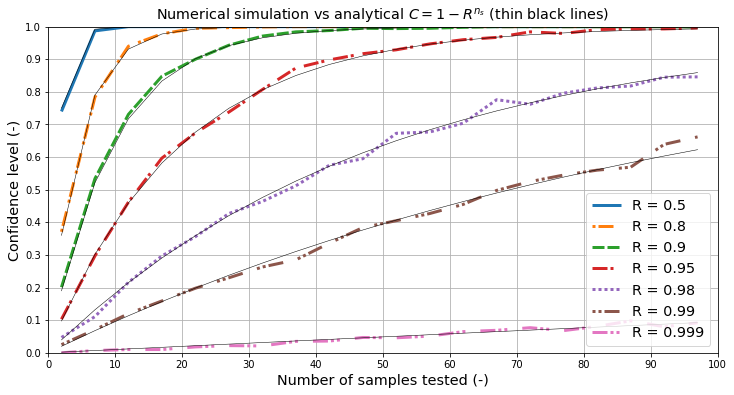

In [5]:
plt.figure(figsize=(12,6))

linestyles = [(0,()), 
              (0,(1,1,5,3)),
              (0,(4,1)), 
              (0,(5,1,1,3)), 
              (0,(1,1)), 
              (0,(1,1,1,1,5,5)), 
              (0,(5,1,1,1,1,5))]
linewidth = 3

for j, p in enumerate(reliabilities):
    confidence_of_catching_p_reliable_failures = [frequency_of_catching_subpar_samples[p][n_s] for n_s in n_samples]
    plt.plot(n_samples, confidence_of_catching_p_reliable_failures, label="R = {}".format(p), 
             linestyle=linestyles[j], linewidth=linewidth)
    plt.plot(n_samples, 1-p**n_samples, linestyle='-', linewidth=0.5, color='black')
plt.grid()

plt.xlim([0,100])
plt.ylim([0,1])
fontsize = 'x-large'
plt.legend(loc='best', fontsize=fontsize)

plt.title("Numerical simulation vs analytical $C = 1 - R^{n_s}$ (thin black lines)", fontsize=fontsize)
plt.xlabel("Number of samples tested (-)", fontsize=fontsize)
plt.ylabel("Confidence level (-)", fontsize=fontsize)
plt.xticks(np.arange(0,101,10))
plt.yticks(np.linspace(0,1,11))
    

print("")

The numerical simulations are in line with the analytical solution derived above. 

All the usual disclaimers regarding statistical explorations apply: 
The "tested" samples are assumed to be identical and independent. 
The analytical solution is true only in the limit of infinite repetitions. 
And so on.

## Mapping out R vs C analytically

In the above sections we have looked at the question: 
"how many samples are we supposed to test assuming a target $R$ and $C$?" 
In the present section we approach the problem from the other side. 
Assuming we have $n_\mathrm{s}$ samples available, 
what can we learn from a fail/pass test? 

As already mentioned above, 
if all $n_\mathrm{s}$ samples pass the test, 
we forego the opportunity to actually learn something 
(meaning, by opening up a failing sample and learning about the root causes). 
The only statement we can make given a $100\,\%$ pass rate is 
that the underlying population is $R$ reliable with $C$ confidence, 
related to each other through Eq. (\ref{eq:CRn}) and (\ref{eq:n_lnCR}), respectively.


As an example let's assume we have $n_\mathrm{s}=4$ samples available. 
What is the underlying reliability $R$ of the population supposed to be 
for us to have a reasonable chance of catching a failing sample 
among these $n_\mathrm{s}=4$ samples?

One way to go about answering this question is to flip a coin: 
tail means the population is impecable and can be shipped, 
head means the population shows some not-further-specified flaws. 
This strategy, stated in this extreme form, does not take the fail/pass test into account in any way whatsoever. 
However, an unrelated coin flip is not actually worth less 
than a test with expected frequency of finding a failing part of $C\leq0.5$.

For example, if none of the $n_\mathrm{s}=4$ samples failed, 
but, if at the same time we were to expect the underlying population to show a reliability 
of at least $R\geq0.84$, 
then the fact that all $n_\mathrm{s}=4$ samples have passed 
is actually less informative than a completely unrelated coin flip!


More generally, from Eq. (\ref{eq:CRn}) we find 
\begin{equation}
R = \sqrt[\leftroot{-2}\uproot{2}n_\mathrm{s}]{1-C}.
\label{eq:nrootC}
\end{equation}

For a test with $n_\mathrm{s}=4$ to be meaningful -- say $C\geq0.9$ -- 
the underlying population has to show a reliability of at most $R=0.56$.


In [6]:

R = lambda C, n_s: (1 - C)**(1/n_s)

def R_summary(C, n_s):
    print('Underlying reliability has to be at most R={:.2f}, given C={} with n_s={}'.format(R(C,n_s),C,n_s))
    
R_summary(0.5,4)
R_summary(0.9,4)

Underlying reliability has to be at most R=0.84, given C=0.5 with n_s=4
Underlying reliability has to be at most R=0.56, given C=0.9 with n_s=4


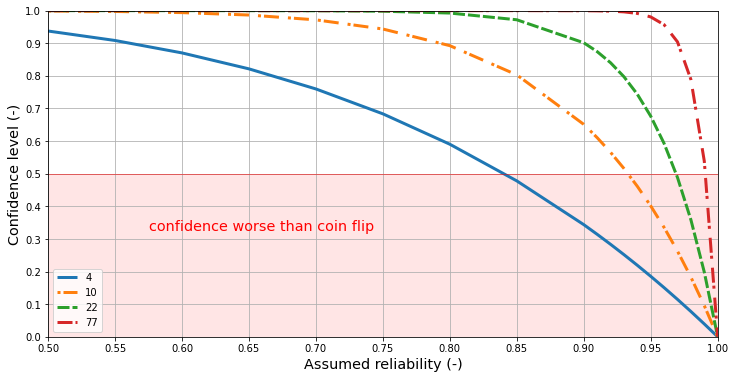

In [7]:
plt.figure(figsize=(12,6))

linestyles = [(0,()), 
              (0,(1,1,5,3)),
              (0,(4,1)), 
              (0,(5,1,1,3)), 
              (0,(1,1)), 
              (0,(1,1,1,1,5,5)), 
              (0,(5,1,1,1,1,5))]
linewidth = 3

sample_ns = [4, 10, 22, 77]
assumed_Rs = np.array(list(np.linspace(0.5,0.9,9)) + list(np.linspace(0.91,1,10)))

for j, n in enumerate(sample_ns):
    plt.plot(assumed_Rs, 1-assumed_Rs**n, label='{}'.format(n),
             linestyle=linestyles[j], linewidth=linewidth)
    
# caution: C<0.5 means confidence worse than a coin flip
# i.e. don't even think about ending up in this region!
warning_color = 'red'
plt.fill_between([0.5,1], [0.5,0.5], facecolor=warning_color, alpha=0.1)
plt.axhline(y=0.5, color='red', linewidth=0.5)
plt.text(0.575,0.325,'confidence worse than coin flip', fontsize=fontsize, color=warning_color)

# formating
plt.legend(loc='best')
plt.grid('on')

plt.xlabel("Assumed reliability (-)", fontsize=fontsize)
plt.ylabel("Confidence level (-)", fontsize=fontsize)
plt.xticks(np.linspace(0.5,1,11))
plt.xlim([0.5,1])
plt.yticks(np.linspace(0,1,11))
plt.ylim([0,1])

print("")

## Further reading

This notebook was originally inspired by an Accendo Reliability podcast on the topic  
<https://accendoreliability.com/podcast/arw/making-use-reliability-statistics/>

Regarding what we can learn from a failed vs passed test (equally applicable for software and hardware), 
I can recommend  
K. Henney “A Test of Knowledge” <https://medium.com/@kevlinhenney/a-test-of-knowledge-78f4688dc9cb>